# $GPy$

In [30]:
import os
import sys
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
from matplotlib import pyplot as plt
import GPy as gp
import numpy as np

#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True

InteractiveShell.ast_node_interactivity = 'all'

matplotlib.rcParams['figure.figsize'] = (16,9)
matplotlib.rcParams['font.size'] = 24
matplotlib.rcParams['font.family'] = 'serif'

np.random.seed(1)

## Making our latent function

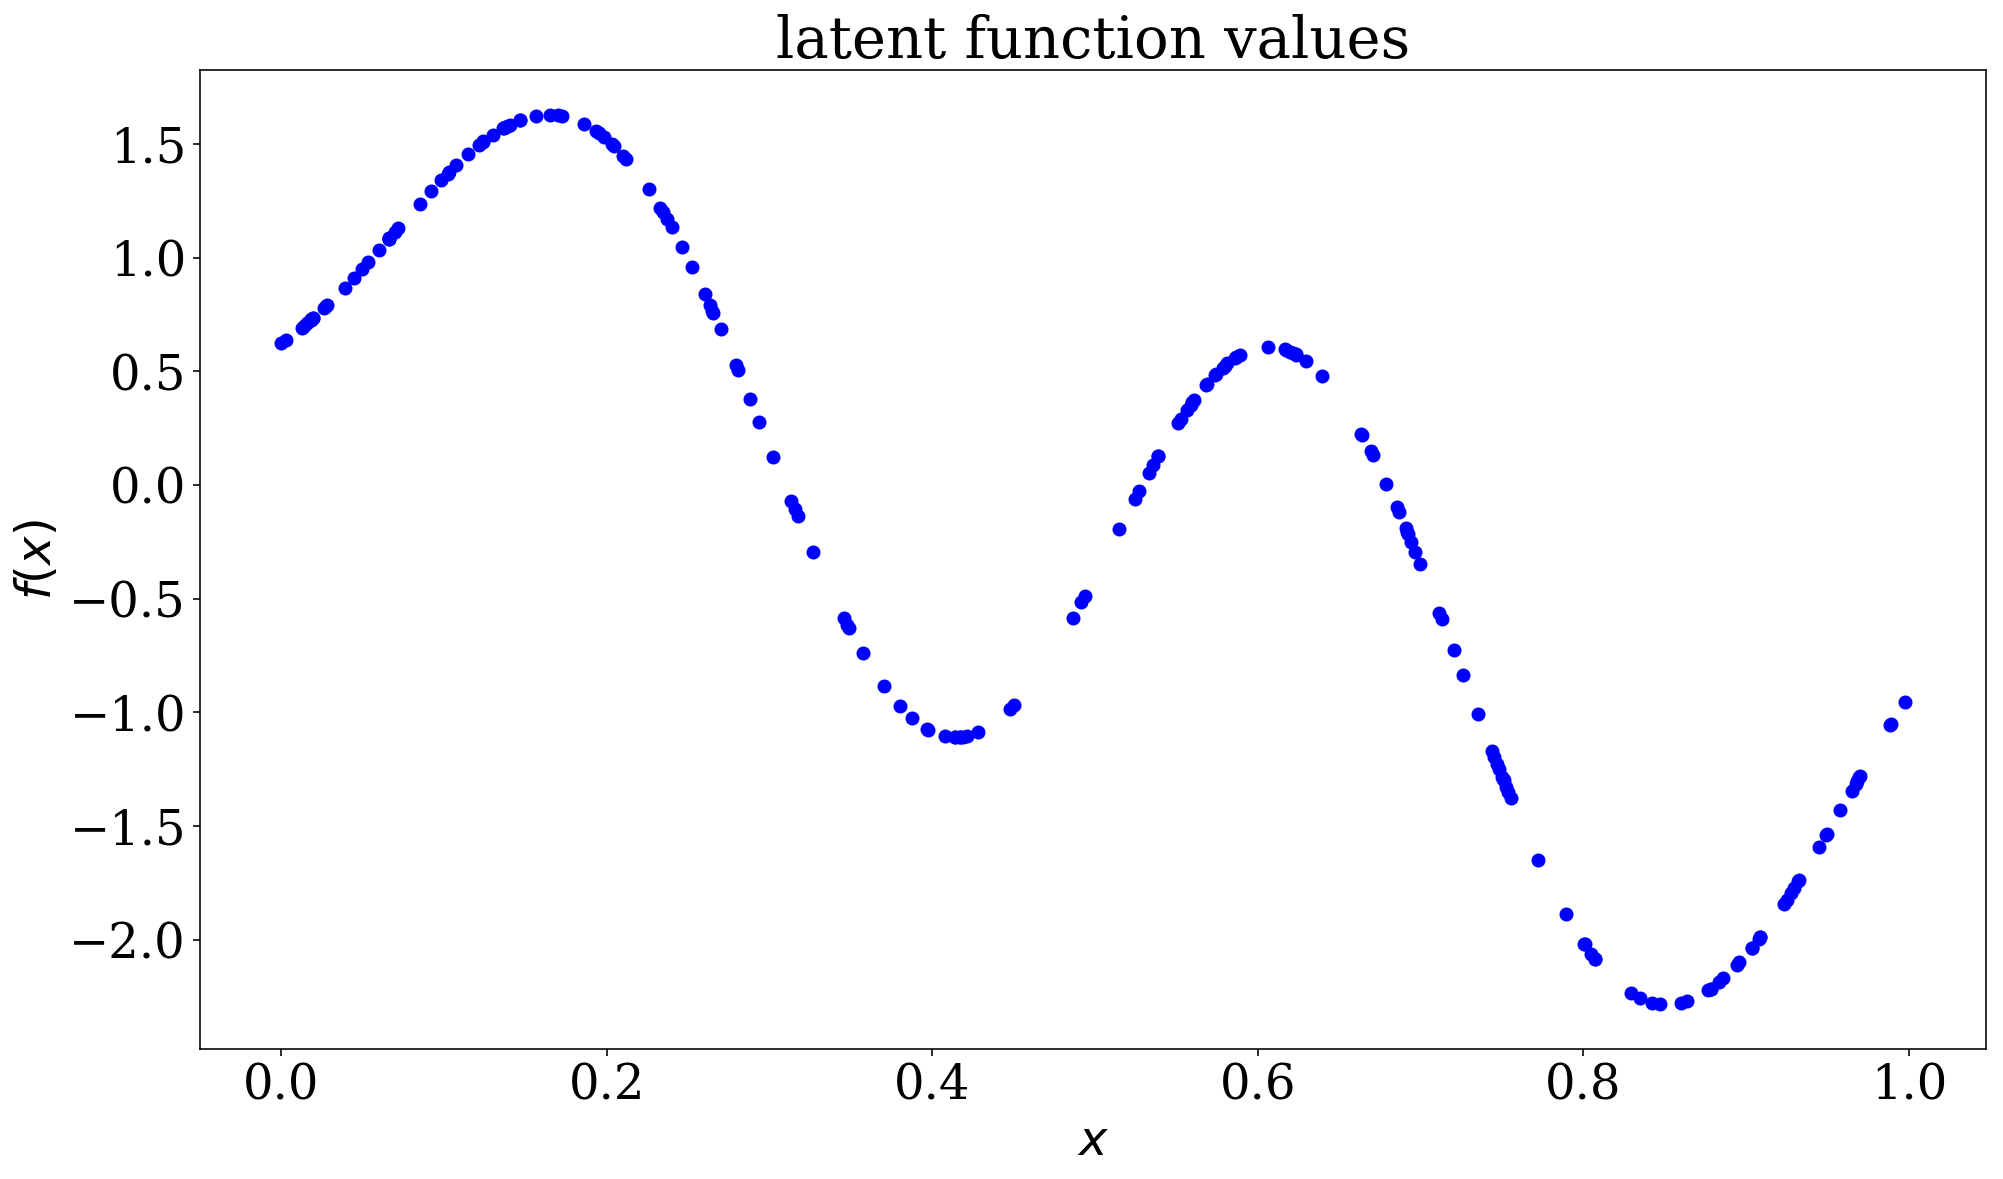

In [31]:
k = gp.kern.RBF(1, variance=7., lengthscale=0.2)
X = np.random.rand(200, 1)

# latent function
f = np.random.multivariate_normal(np.zeros(200), k.K(X))

plt.plot(X, f, 'bo');
plt.title('latent function values');
plt.xlabel('$x$');
plt.ylabel('$f(x)$');

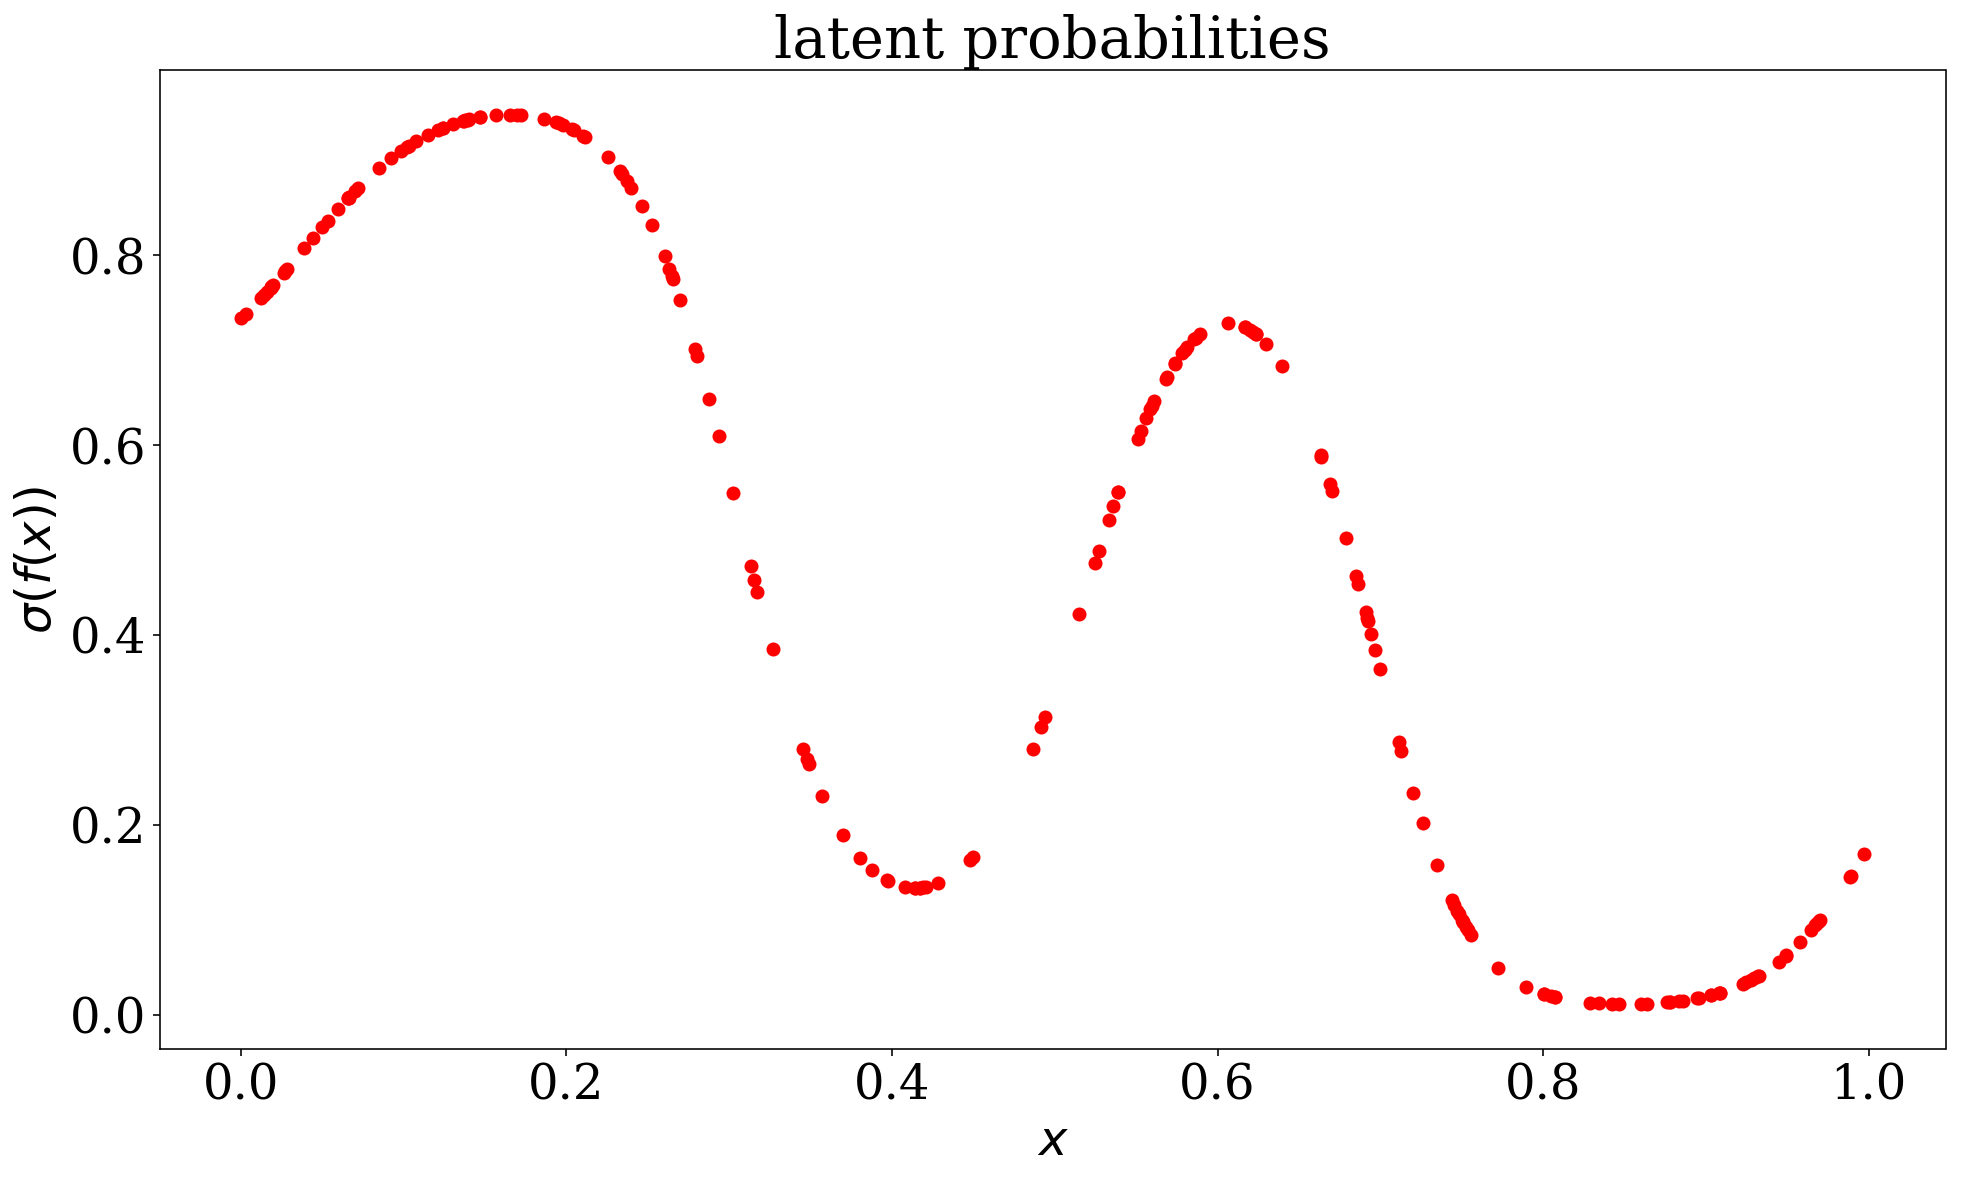

In [32]:
# squashing the latent function with probits

likelihood = gp.likelihoods.Bernoulli()
p = likelihood.gp_link.transf(f) #squash
plt.plot(X, p, 'ro');
plt.title('latent probabilities');plt.xlabel('$x$');plt.ylabel('$\sigma(f(x))$');

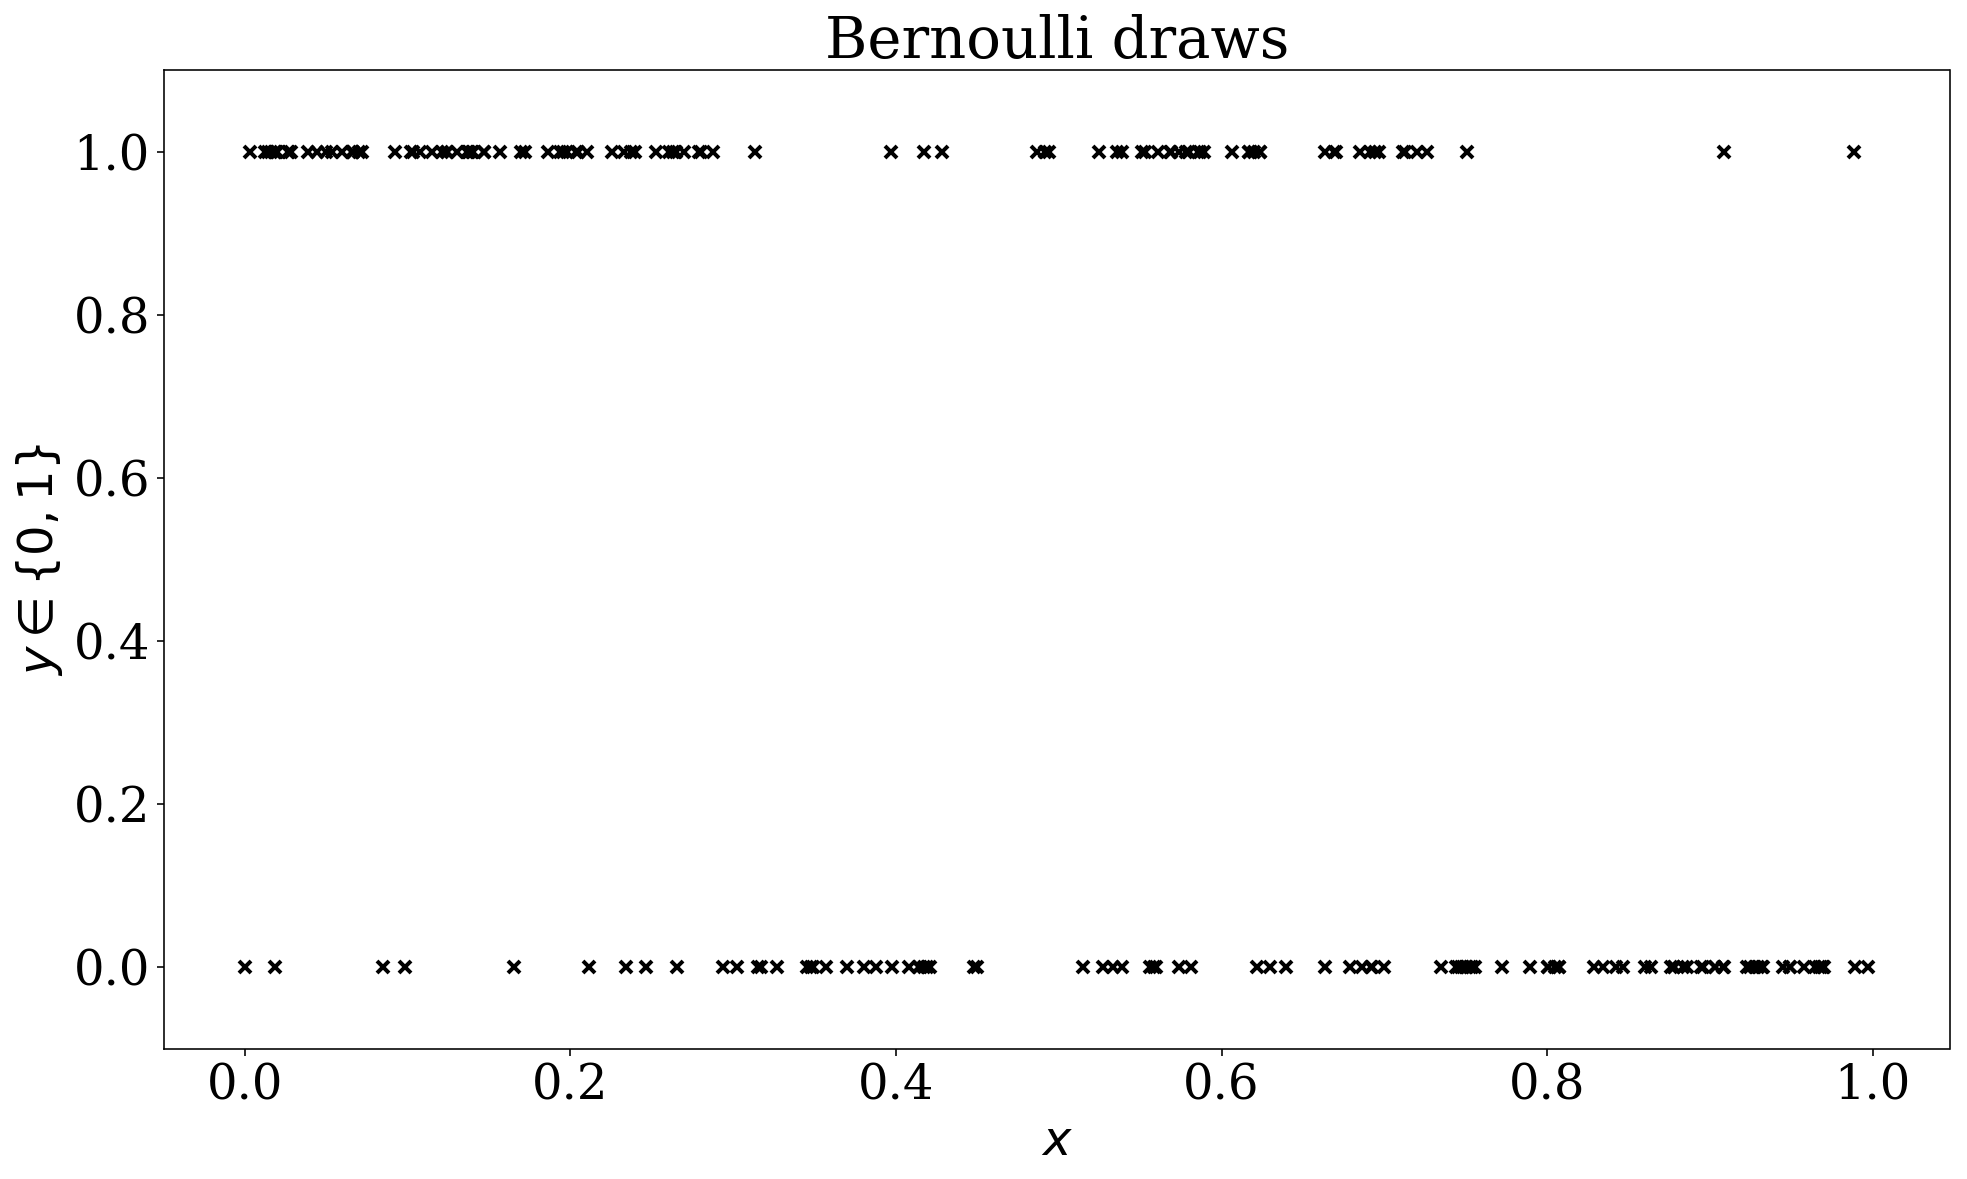

In [33]:
# get binary bernoulli from squashed values
Y = likelihood.samples(f).reshape(-1,1)
plt.plot(X, Y, 'kx', mew=2);plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws');
plt.xlabel('$x$');
plt.ylabel('$y \in \{0,1\}$');

## Infering with GP

* In this case we wish to know, given the observed binary variables, can we recover the latent function, the associated probabilities, and the variance and lengthscale of the GP that we believe produced the data


Name : gp
Objective : 101.52602911311774
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    7.0  |      +ve      |        
  rbf.lengthscale  |    0.2  |      +ve      |        


 /home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


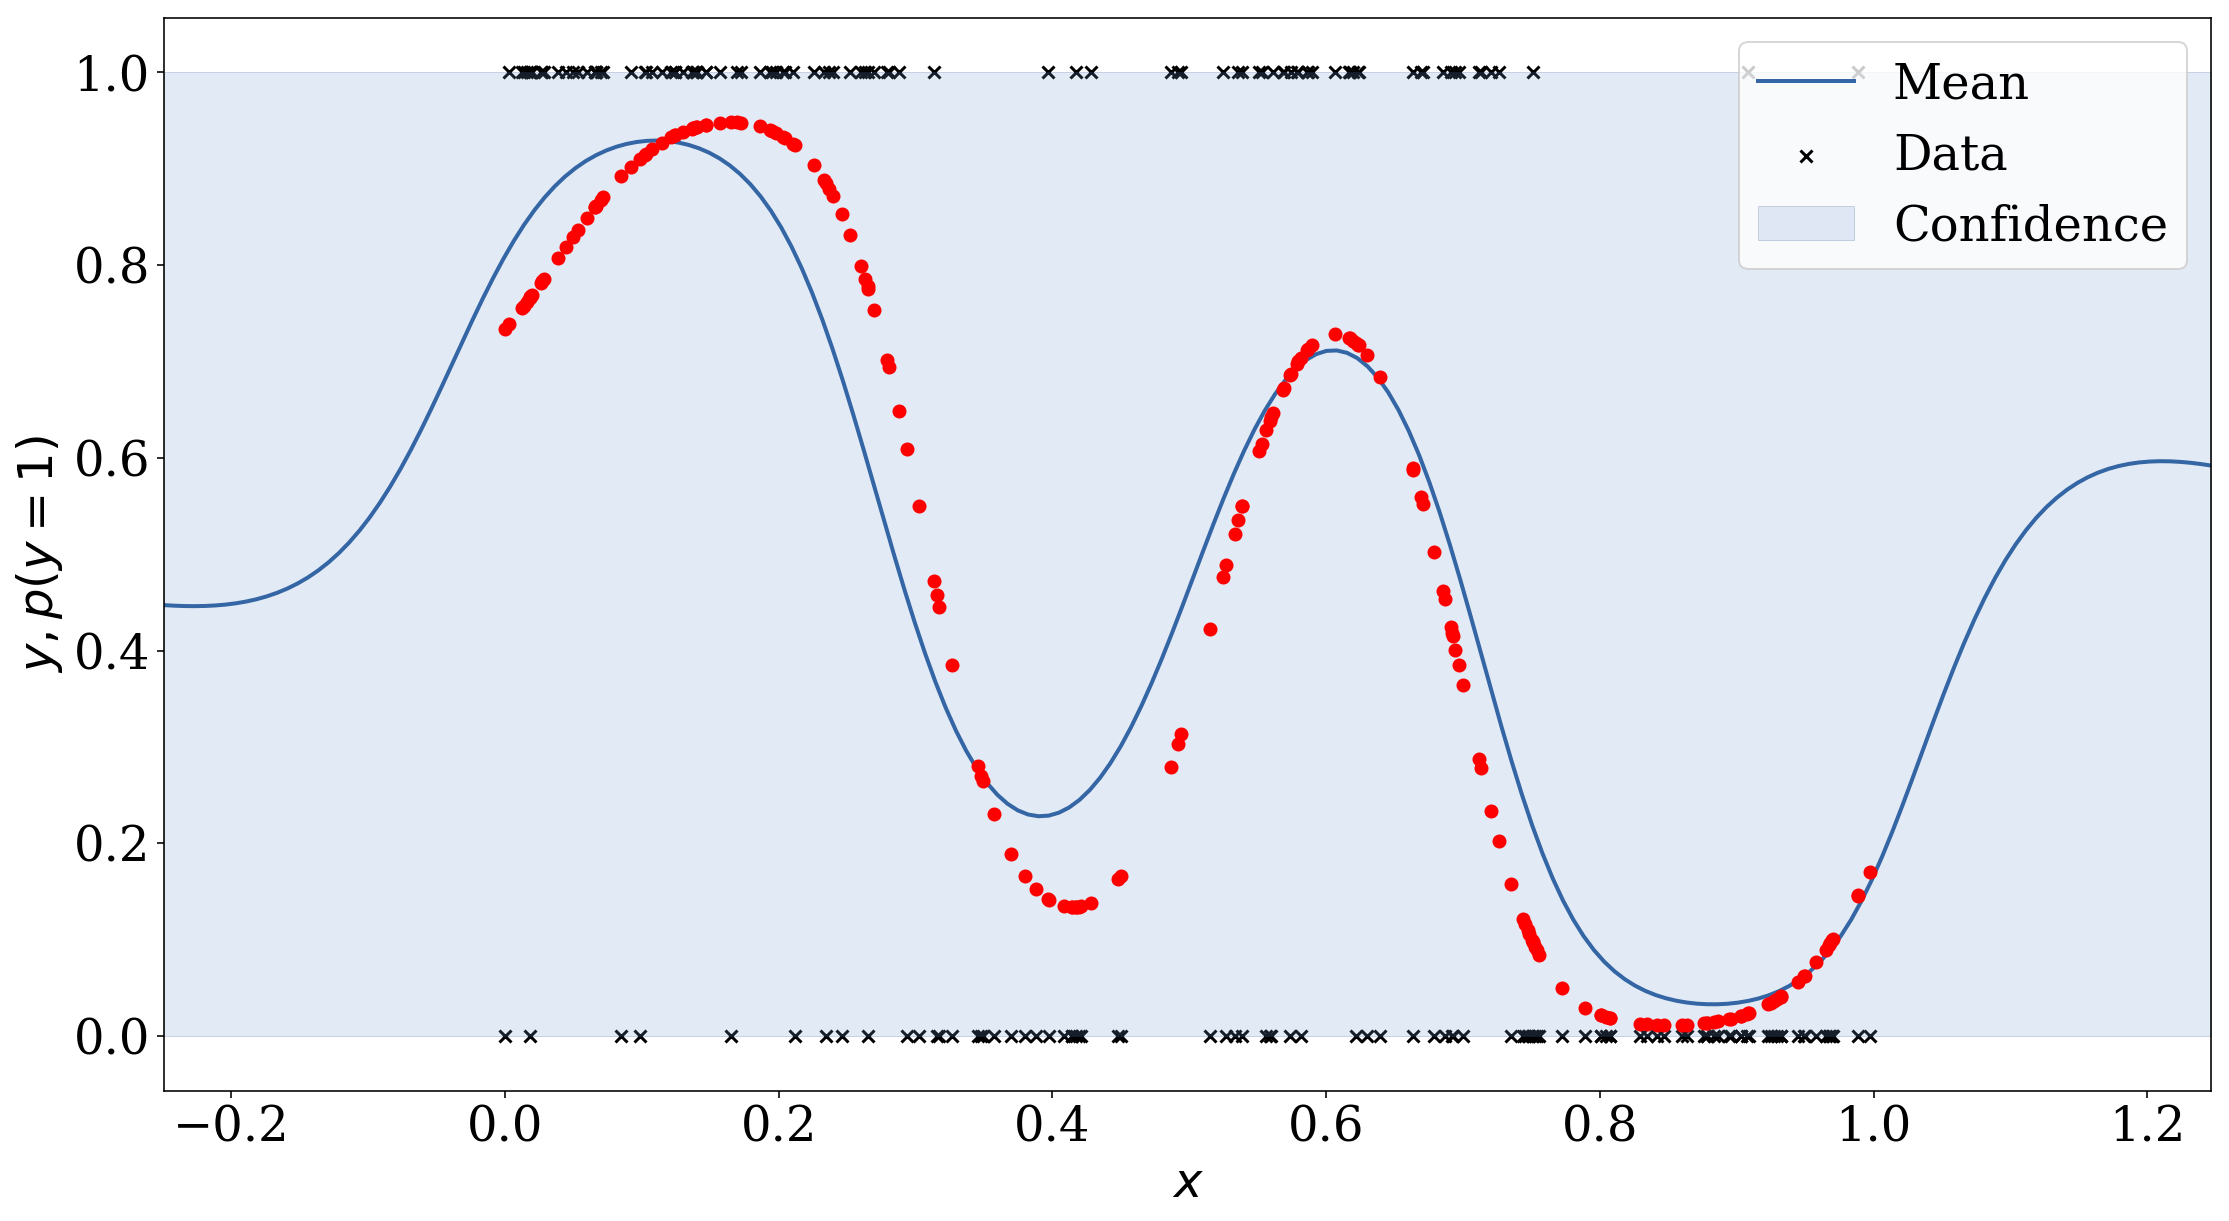

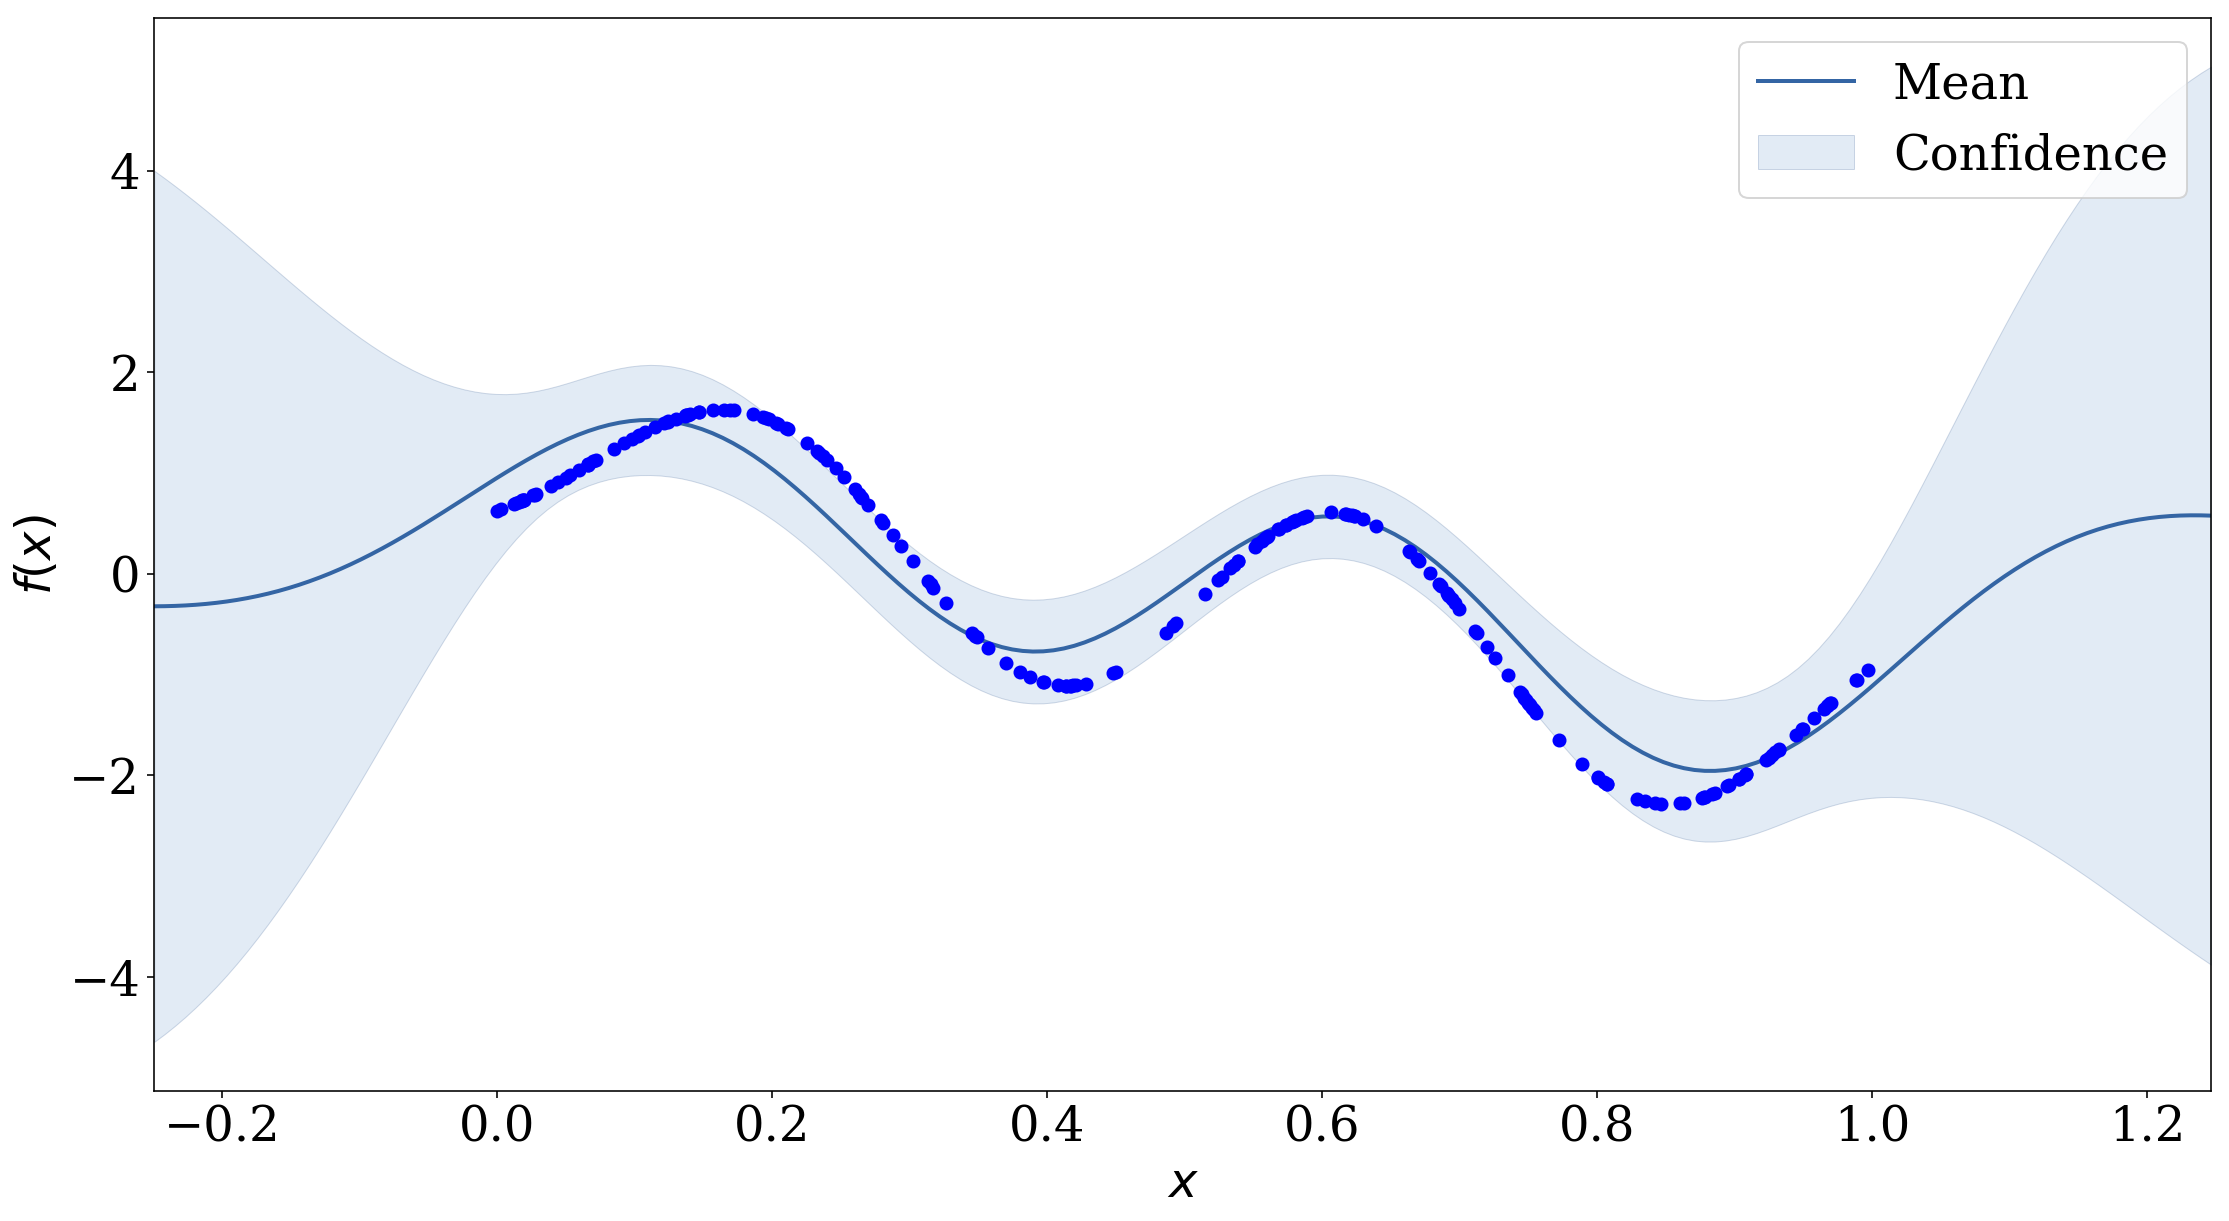

In [34]:
# initialize the model with correct variance and lengthscale
model = gp.core.GP(X=X,
                   Y=Y,
                   kernel = k,
                   inference_method=gp.inference.latent_function_inference.expectation_propagation.EP(),
                   likelihood=likelihood)

print(model)

model.plot();
plt.plot(X, p, 'ro');
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$');

model.plot_f();
plt.plot(X, f, 'bo');
plt.ylabel('$f(x)$');plt.xlabel('$x$');


Name : gp_classification
Objective : 114.55764812981663
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |        


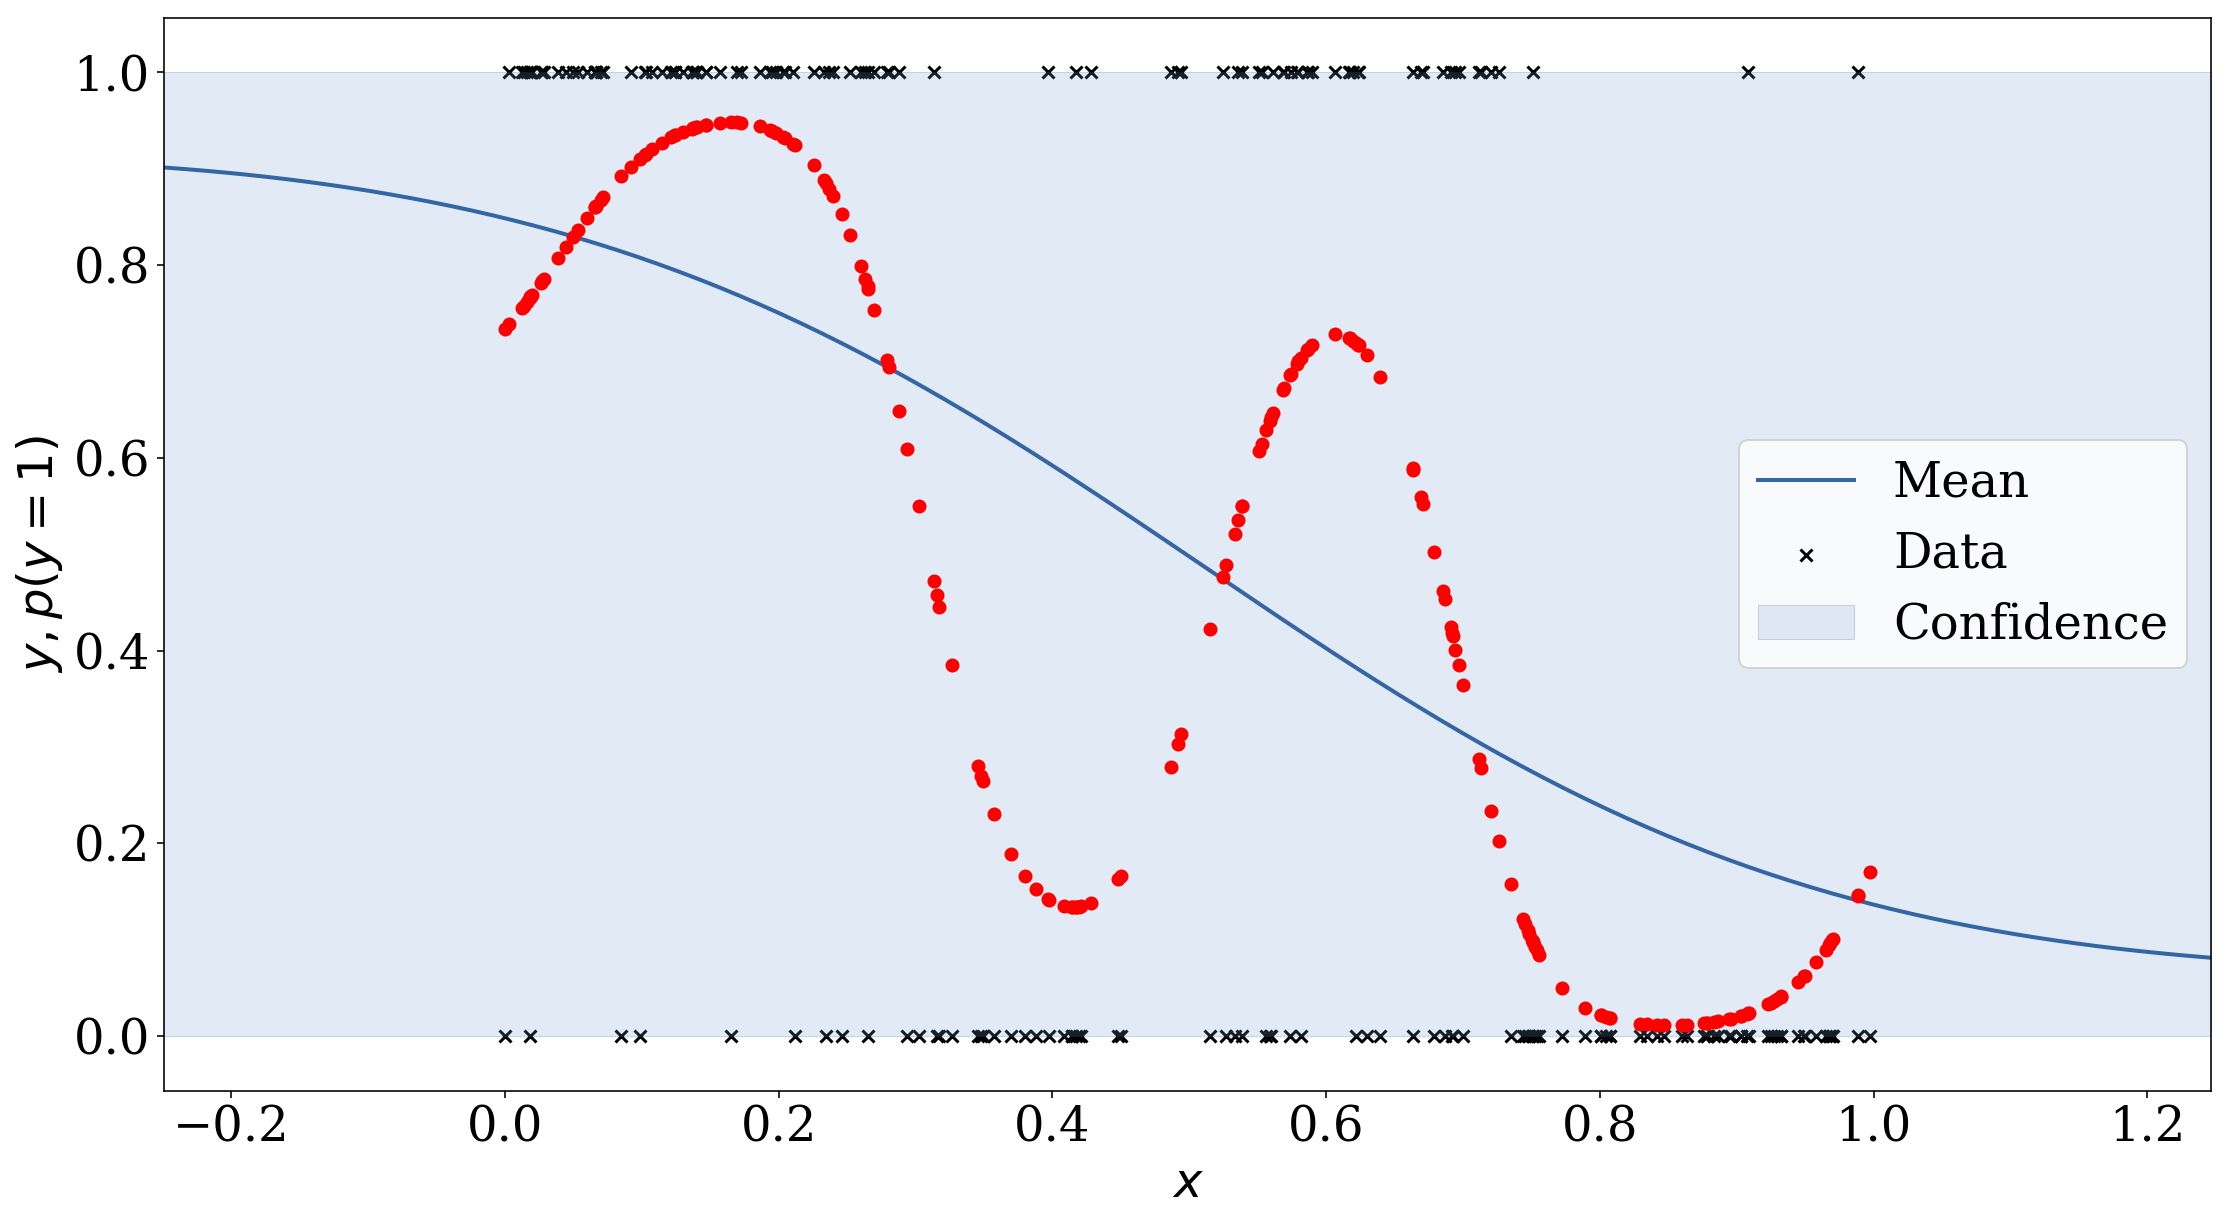

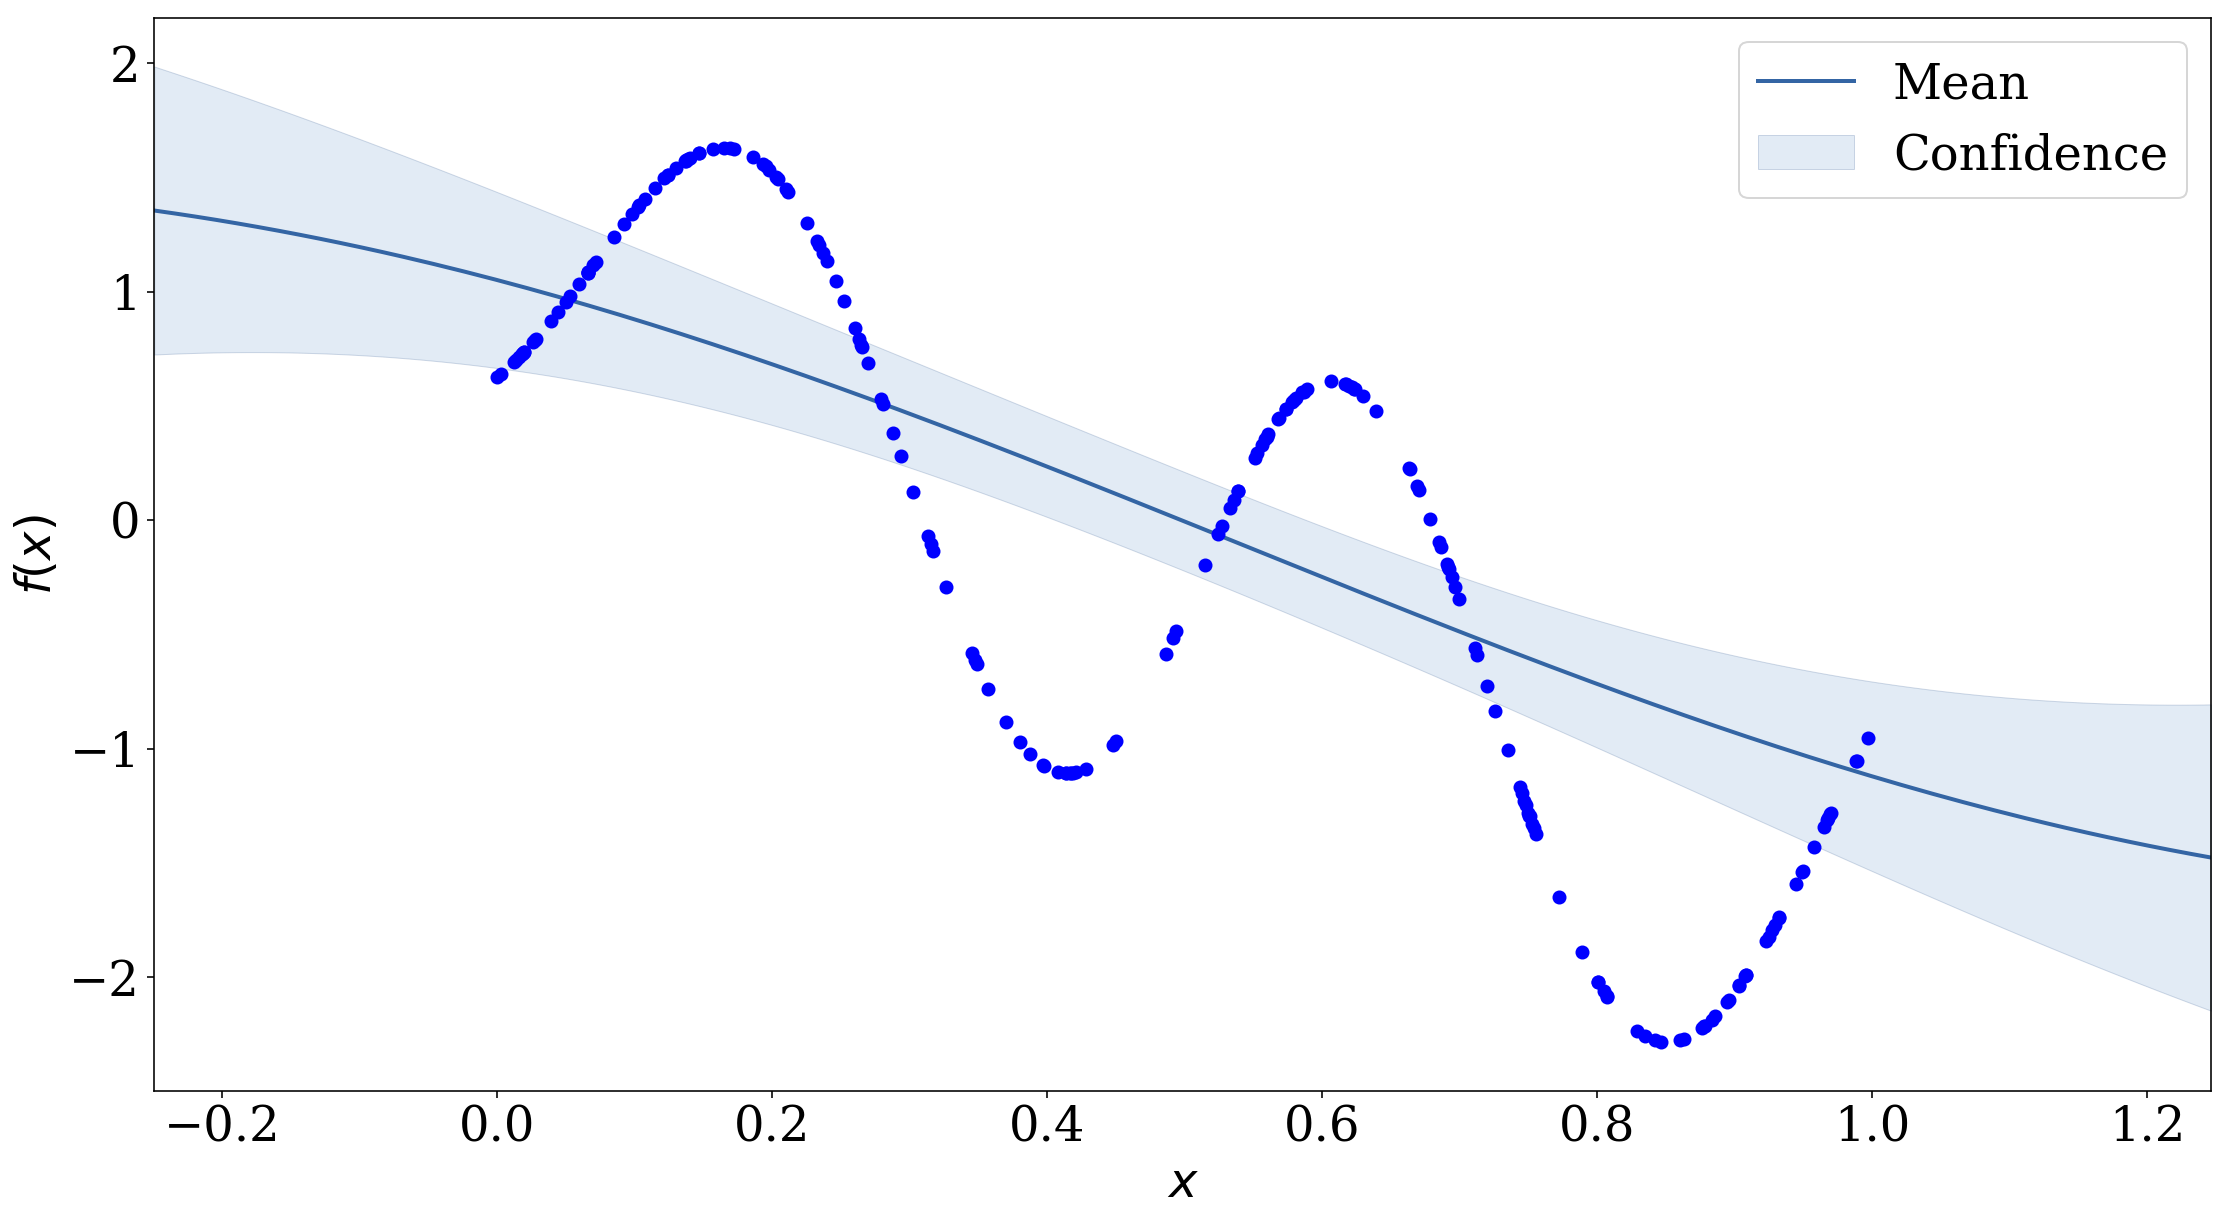

In [35]:
# also using a simpler init, notice how the variance and lengthscale are incorrect 
model_ = gp.models.GPClassification(X,Y)
print(model_)

model_.plot();
plt.plot(X, p, 'ro');
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$');

model_.plot_f();
plt.plot(X, f, 'bo');
plt.ylabel('$f(x)$');plt.xlabel('$x$');


Name : gp_classification
Objective : 114.55764813057135
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |        


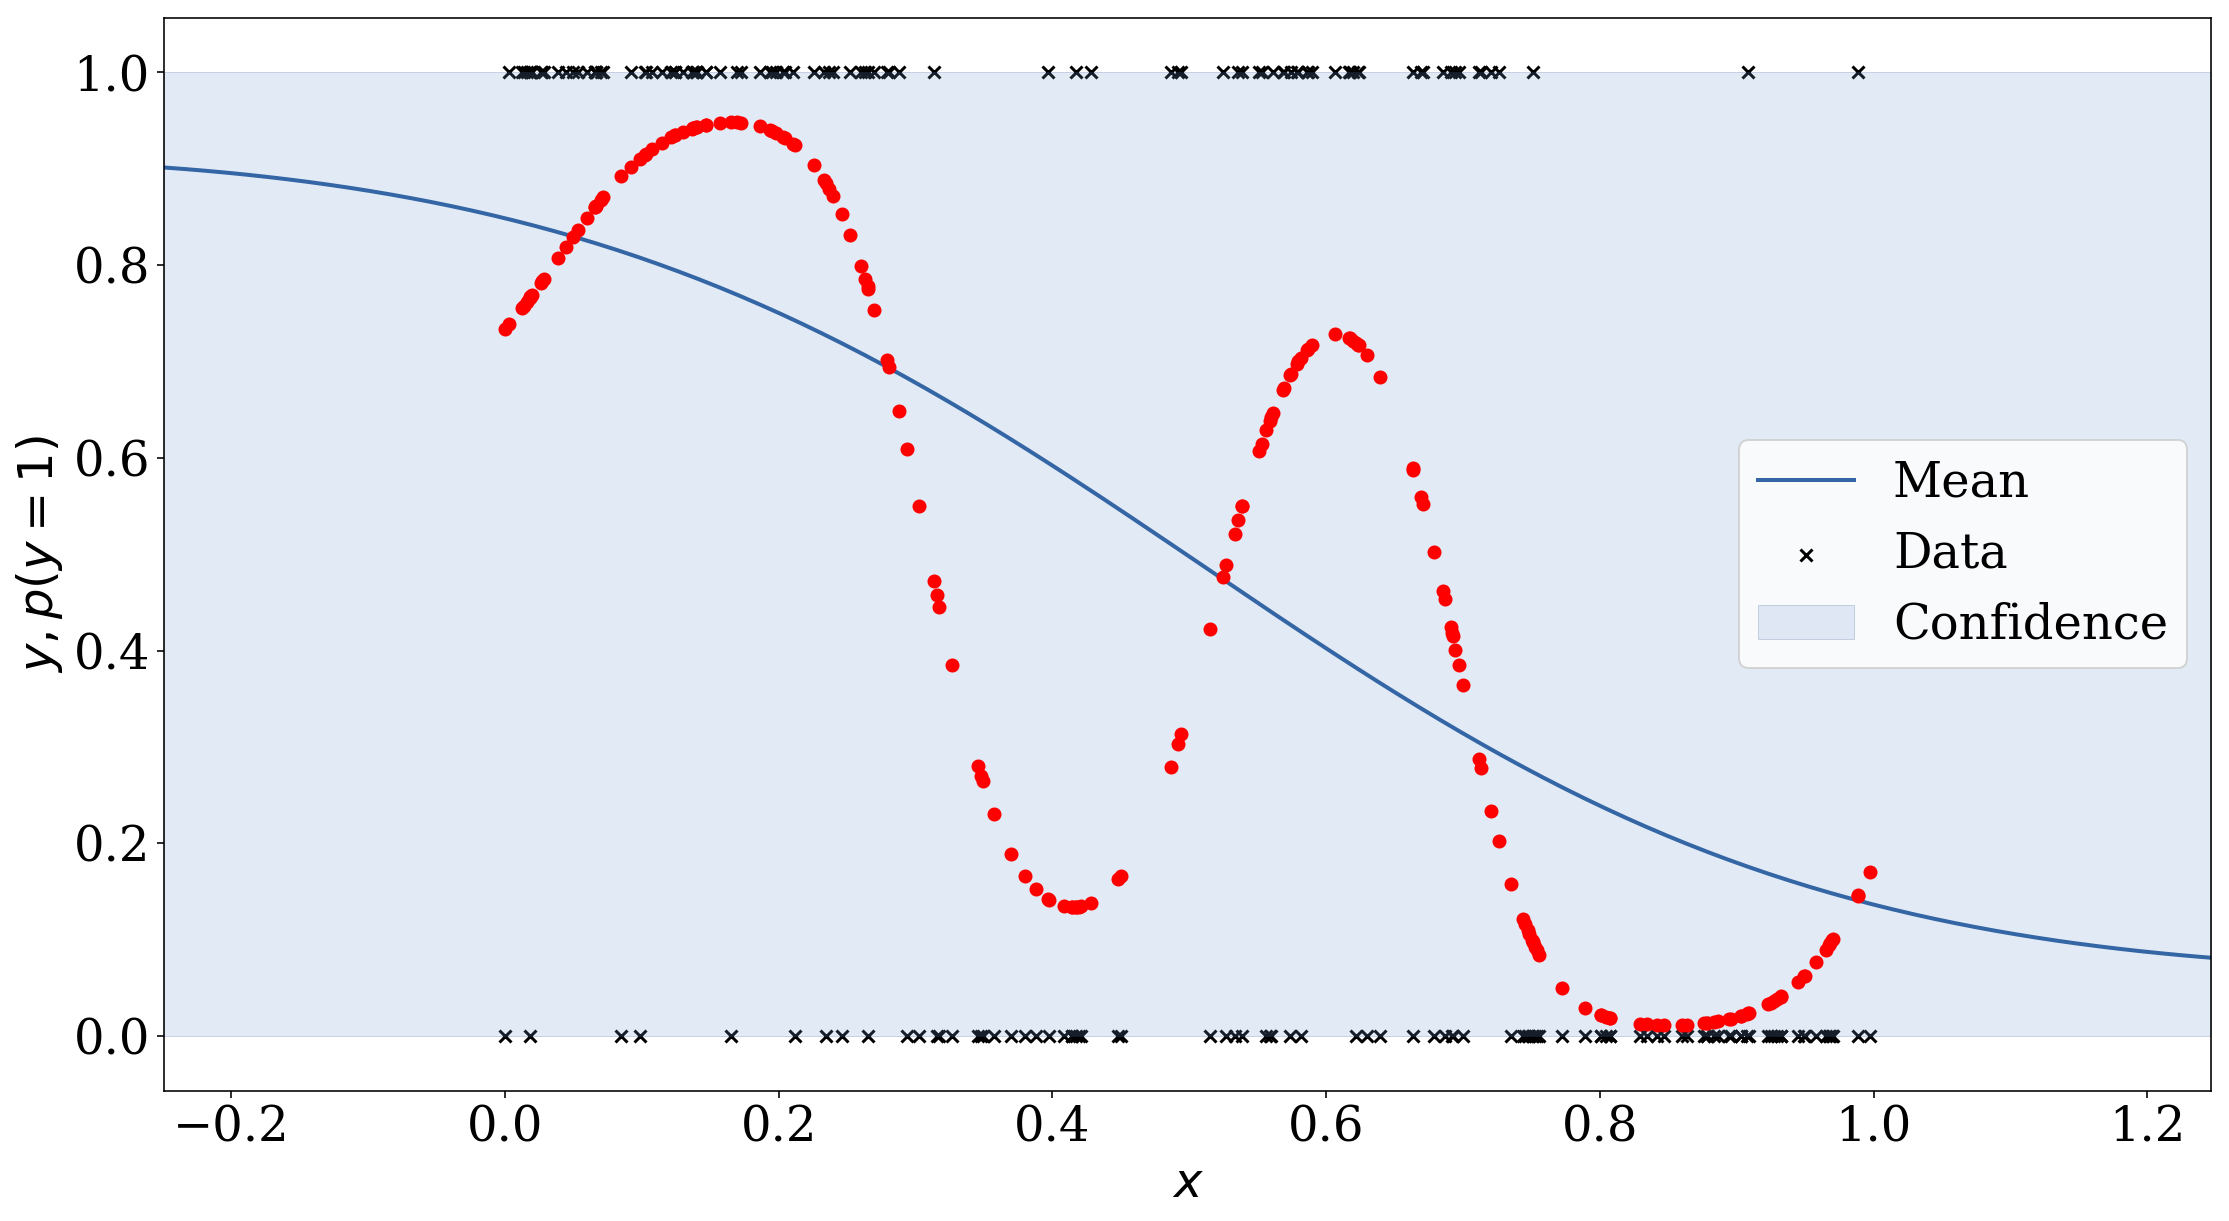

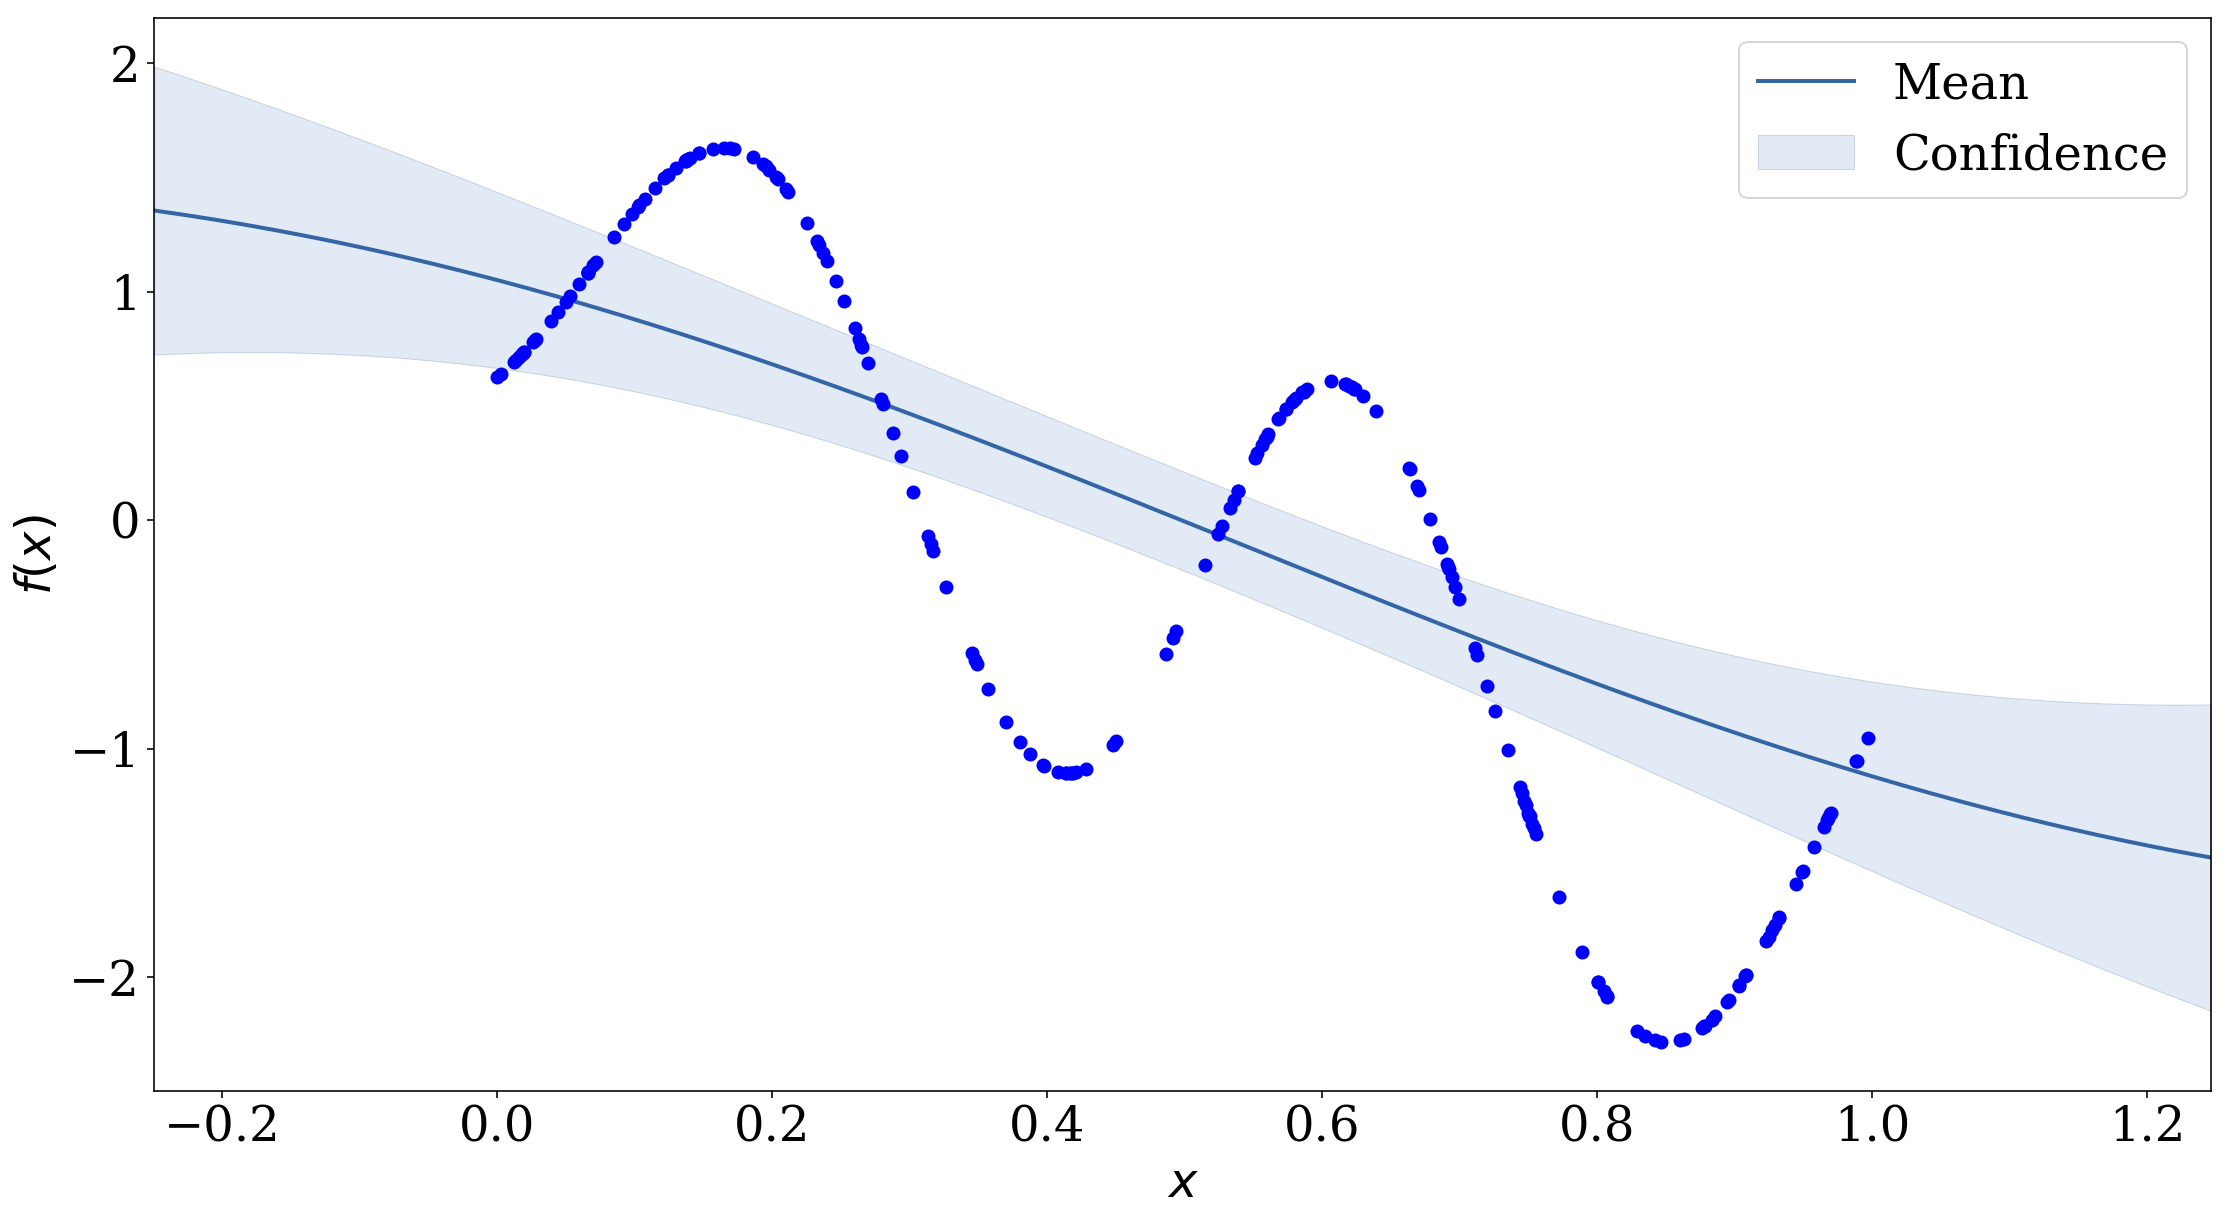

In [36]:
# also using a simpler init, notice how the variance and lengthscale are incorrect 
model_ = gp.models.GPClassification(X,Y)
print(model_)

model_.plot();
plt.plot(X, p, 'ro');
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$');

model_.plot_f();
plt.plot(X, f, 'bo');
plt.ylabel('$f(x)$');plt.xlabel('$x$');

In the above plots, we can see the posterior over the latent probabilities (top) and latent continuous function values (bottom). We've already run $EP$ to obtain the approximate posterior and marginal likelihood. The above plots suggest that the lengthscale of the kernel is incorrect for this problem, so we'll optimize the parameters of the kernel against the approximate marginal likelihood, $p(y|\mathcal{M})$, that represents how probable the data is given our model, $\mathcal{M}$.

To do this, we interleave runs of $EP$ with optimization of the parameters using gradient descent methods. $EP$ is a method for fitting a Gaussian to the posterior, $p(f|y)$
, of the latent (hidden) function, given the data. Whilst the parameters are being optimized, the $EP$ approximation (the parameters of the $EP$ factors) is fixed.

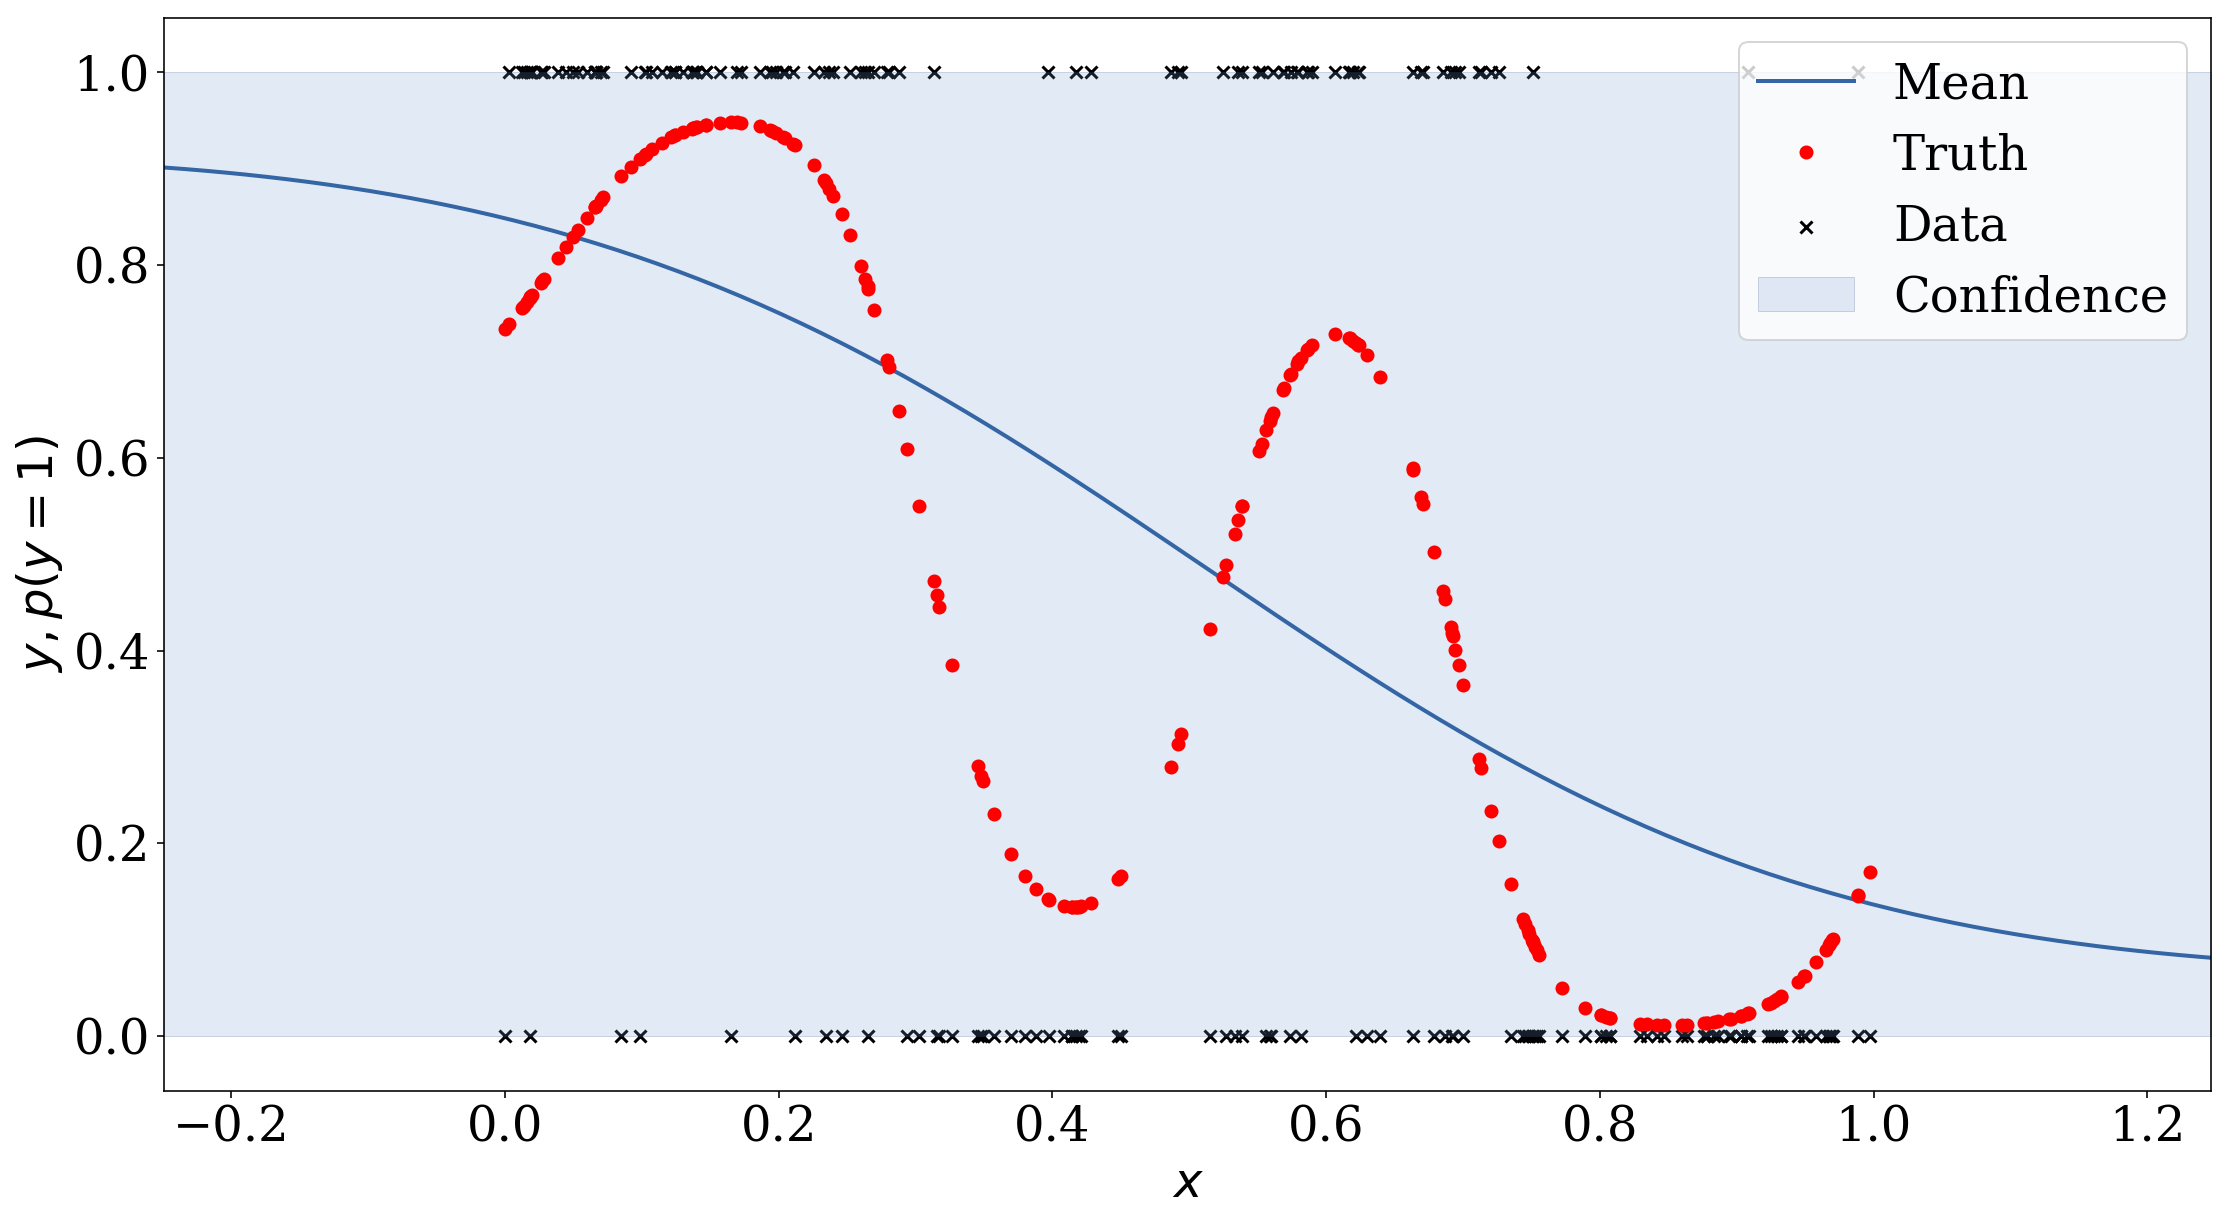

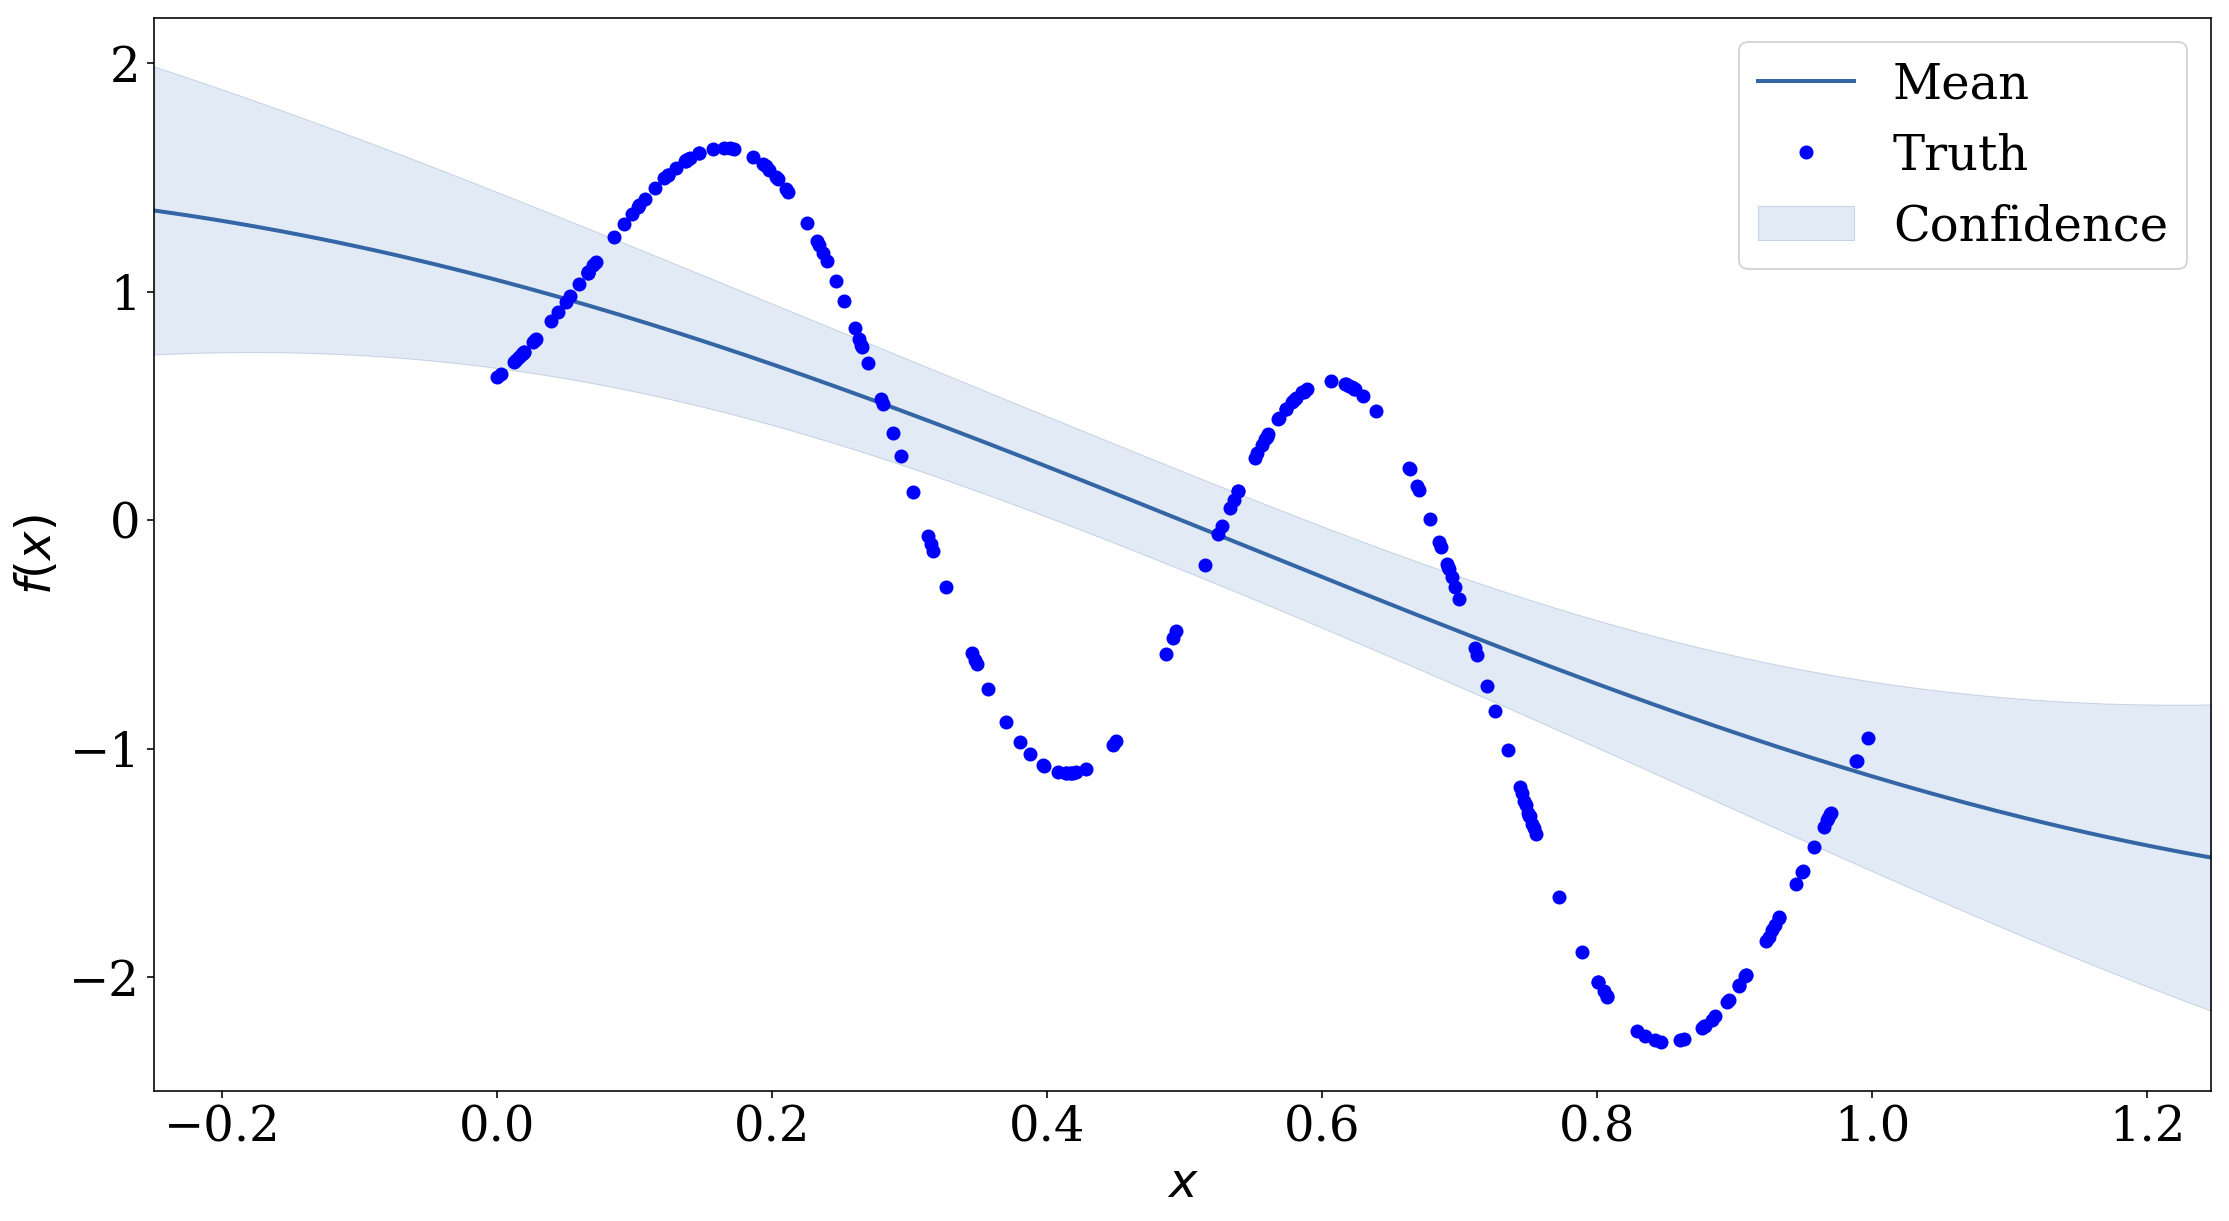

In [37]:
model_.plot()
plt.plot(X, p, 'ro', label='Truth');
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$');
plt.legend(loc='upper right');
model_.plot_f()
plt.plot(X, f, 'bo', label='Truth');
plt.ylabel('$f(x)$');plt.xlabel('$x$');
plt.legend();

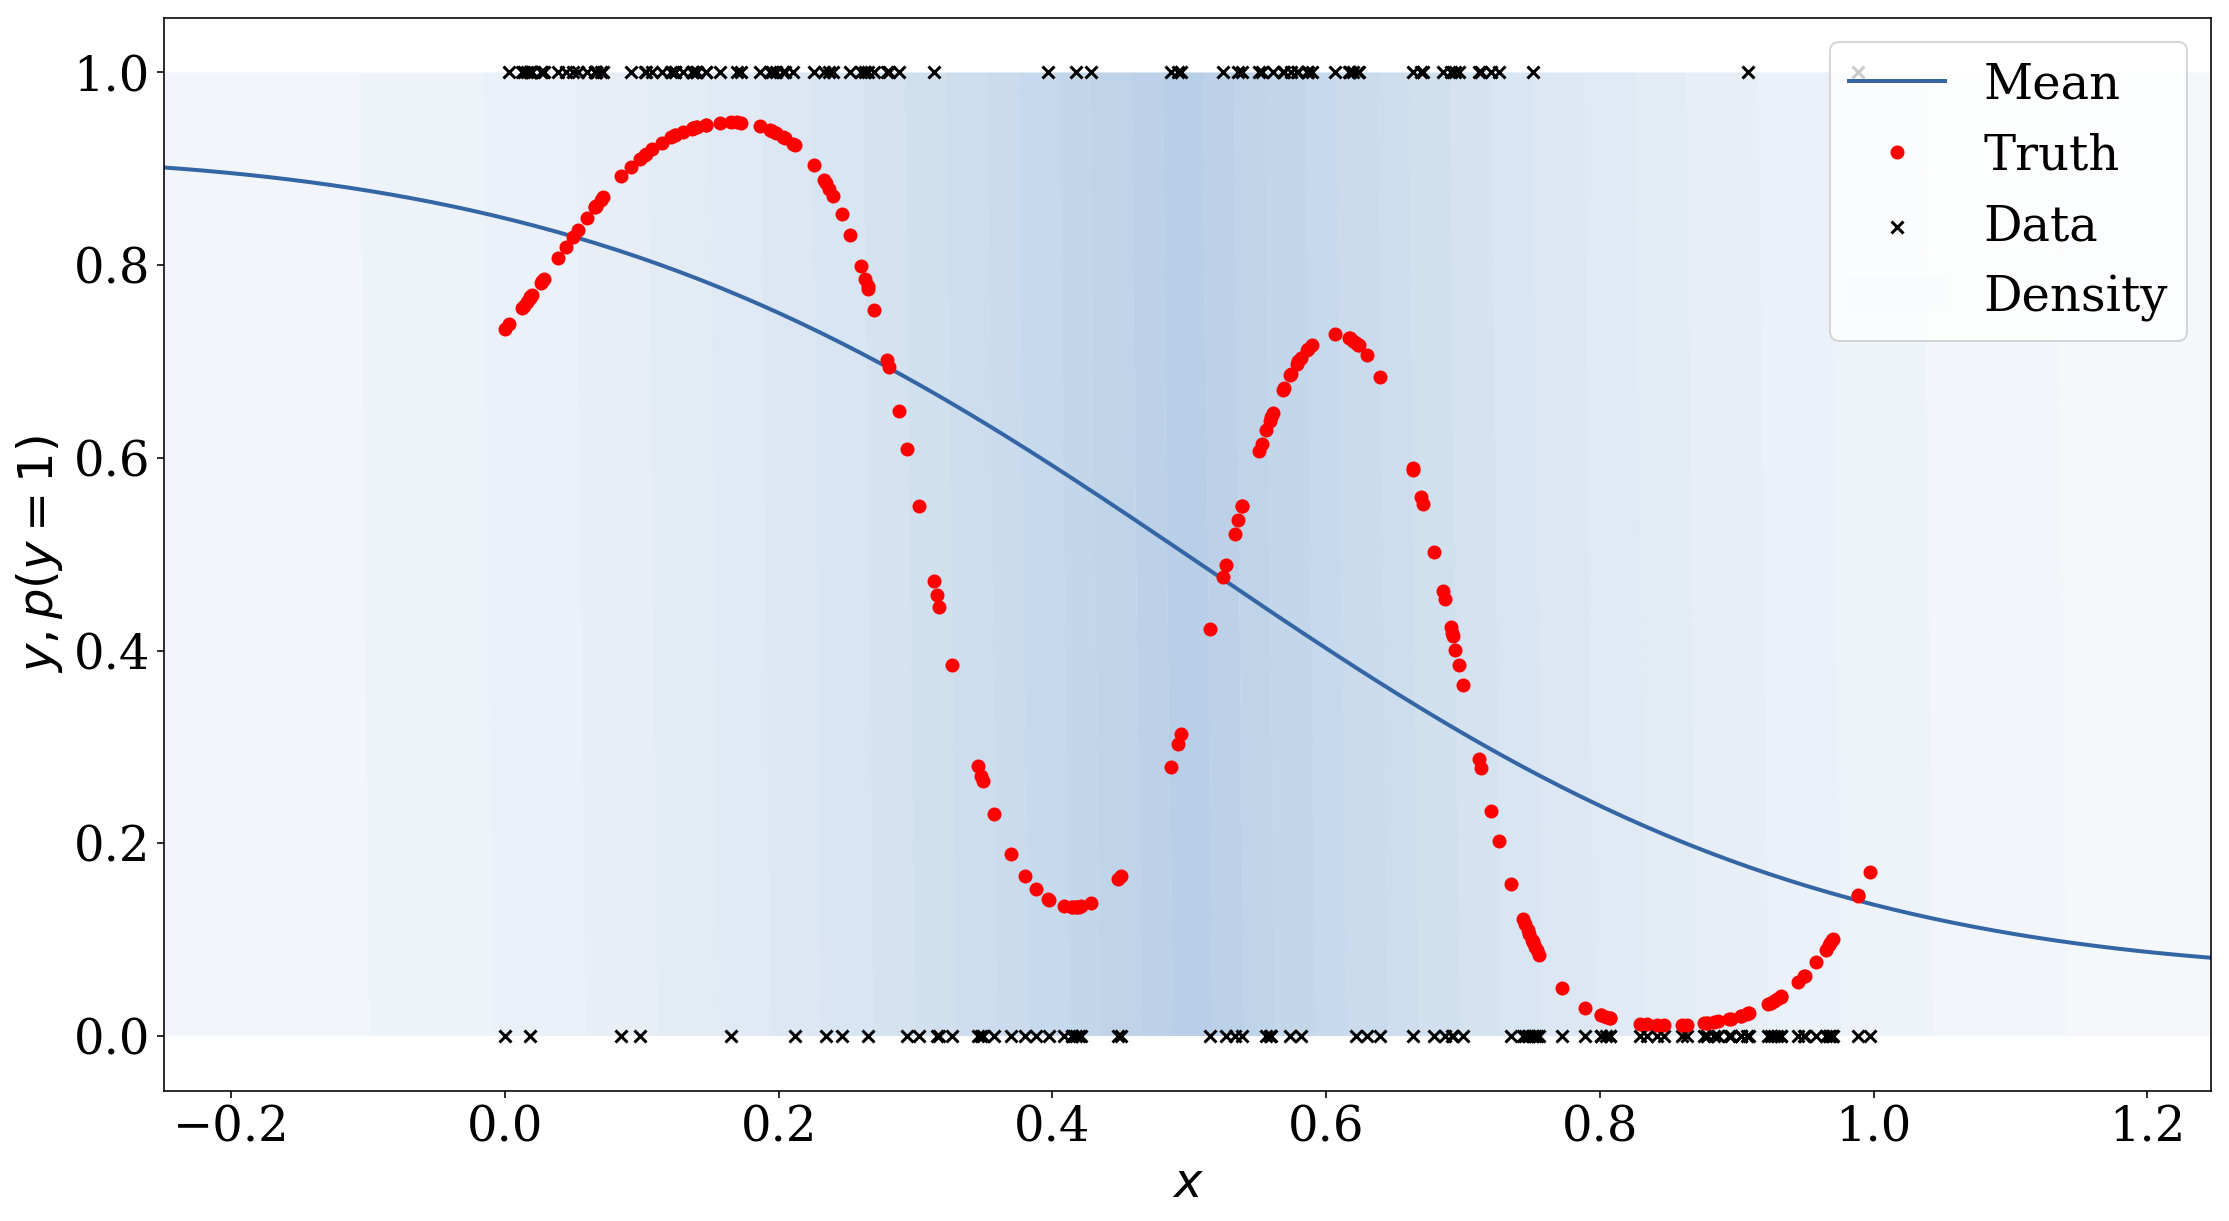

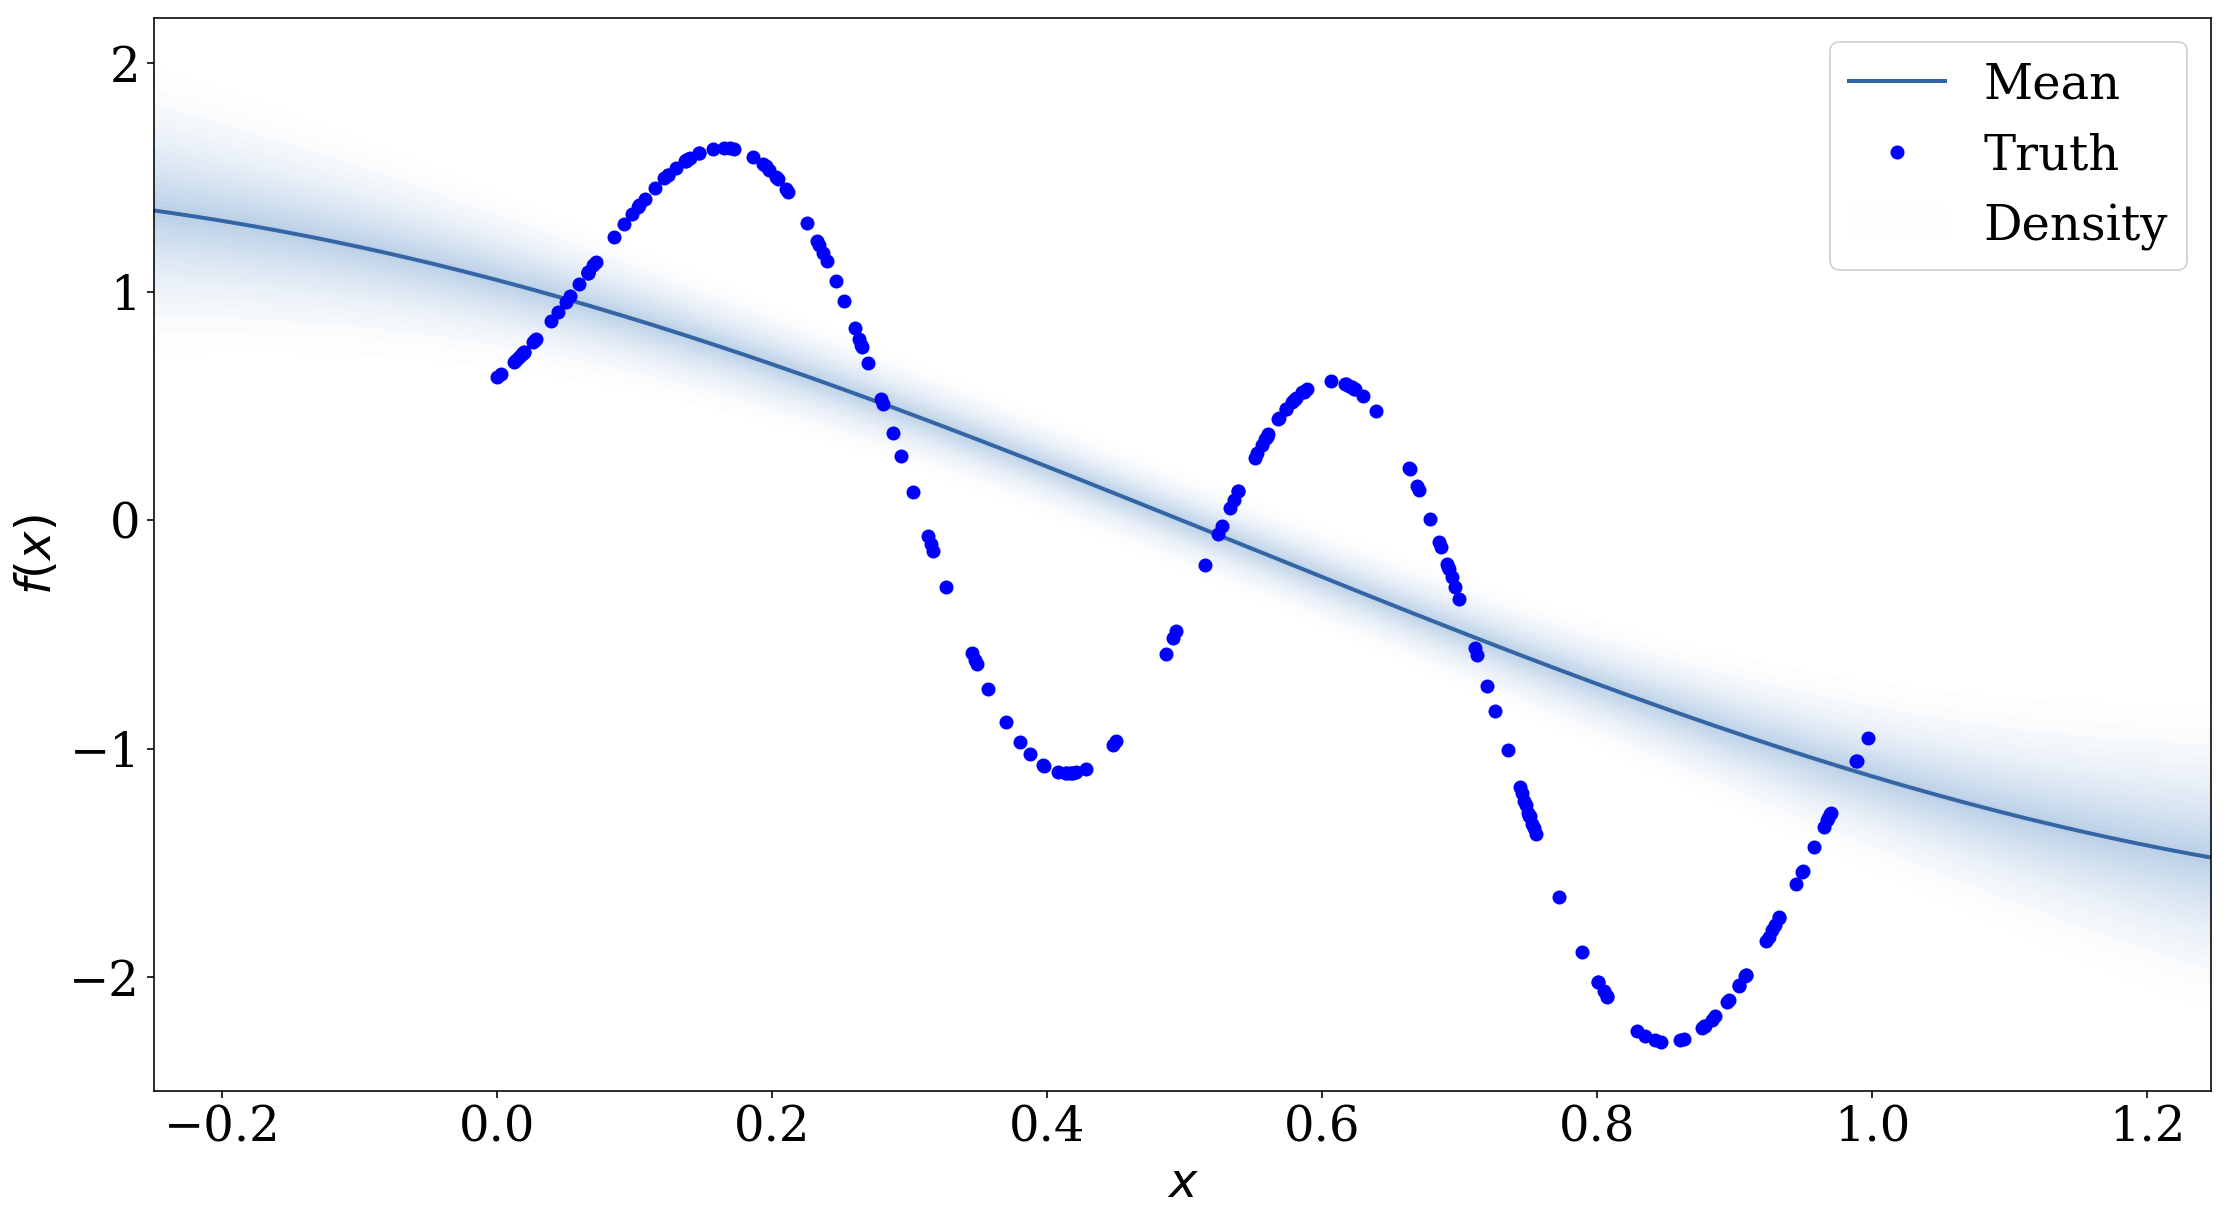

In [38]:
# fine grained plotting
model_.plot(plot_density=True)
plt.plot(X, p, 'ro', label='Truth');
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$');
plt.legend(loc='upper right');
model_.plot_f(plot_density=True)
plt.plot(X, f, 'bo', label='Truth');
plt.ylabel('$f(x)$');plt.xlabel('$x$');
plt.legend();